In [68]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense, Input, Add, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.applications import ResNet50
from sklearn.utils import resample
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.applications import VGG16

In [69]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [70]:
# Define dataset directory
DATASET_DIRECTORY = 'FER2013_MTCNN_SHA-256'

# Image size & batch size
image_size = (48, 48)
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.2  # 20% of training data for validation

In [71]:
# Define ImageDataGenerators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    validation_split=VALIDATION_SPLIT  # Splitting training data
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load Training Data (80%) - Before Oversampling
train_data = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIRECTORY, "train"),
    target_size=image_size,
    batch_size=BATCH_SIZE,
    color_mode="rgb",  # ResNet50 expects RGB
    class_mode="categorical",
    subset="training"  # 80% for training
)

# Load Validation Data (20%)
val_data = train_datagen.flow_from_directory(
    os.path.join(DATASET_DIRECTORY, "train"),
    target_size=image_size,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    subset="validation"  # 20% for validation
)

# Load Test Data (Untouched)
test_data = test_datagen.flow_from_directory(
    os.path.join(DATASET_DIRECTORY, "test"),
    target_size=image_size,
    batch_size=BATCH_SIZE,
    color_mode="rgb",
    class_mode="categorical",
    shuffle=False  # Keep order unchanged for evaluation
)

# Print dataset details (before oversampling)
print(f"Training samples (before oversampling): {train_data.samples}, Classes: {train_data.num_classes}")
print(f"Validation samples: {val_data.samples}")
print(f"Test samples: {test_data.samples}")

Found 18240 images belonging to 7 classes.
Found 4556 images belonging to 7 classes.
Found 6031 images belonging to 7 classes.
Training samples (before oversampling): 18240, Classes: 7
Validation samples: 4556
Test samples: 6031


In [72]:
def balance_test_data(test_data, target_count=500):
    class_indices = test_data.class_indices
    idx_to_class = {v: k for k, v in class_indices.items()}

    image_paths = []
    labels = []
    for subdir in os.listdir(os.path.join(DATASET_DIRECTORY, "test")):
        subdir_path = os.path.join(DATASET_DIRECTORY, "test", subdir)
        if os.path.isdir(subdir_path):
            for img_name in os.listdir(subdir_path):
                if img_name.endswith(('.jpg', '.png')):
                    image_paths.append(os.path.join(subdir_path, img_name))
                    labels.append(class_indices[subdir])

    df = pd.DataFrame({'path': image_paths, 'label': labels})

    balanced_dfs = []
    for class_idx in class_indices.values():
        class_df = df[df['label'] == class_idx]
        current_count = len(class_df)
        if current_count < target_count:
            oversampled_class = resample(class_df, replace=True, n_samples=target_count - current_count, random_state=42)
            balanced_df = pd.concat([class_df, oversampled_class])
        elif current_count > target_count:
            balanced_df = resample(class_df, replace=False, n_samples=target_count, random_state=42)
        else:
            balanced_df = class_df
        balanced_dfs.append(balanced_df)

    balanced_test_df = pd.concat(balanced_dfs)
    balanced_test_df['label'] = balanced_test_df['label'].map(idx_to_class)

    test_datagen = ImageDataGenerator(rescale=1./255)
    test_data_balanced = test_datagen.flow_from_dataframe(
        balanced_test_df,
        x_col='path',
        y_col='label',
        target_size=image_size,
        batch_size=BATCH_SIZE,
        color_mode="rgb",
        class_mode="categorical",
        shuffle=False
    )

    return test_data_balanced

# Replace test_data with balanced test data
test_data = balance_test_data(test_data, target_count=500)

Found 3500 validated image filenames belonging to 7 classes.


In [73]:
def oversample_minority_classes(train_data, target_count=None):
    # Get class indices
    class_indices = train_data.class_indices
    idx_to_class = {v: k for k, v in class_indices.items()}

    # Create a list of image paths and labels
    image_paths = []
    labels = []
    for subdir in os.listdir(os.path.join(DATASET_DIRECTORY, "train")):
        subdir_path = os.path.join(DATASET_DIRECTORY, "train", subdir)
        if os.path.isdir(subdir_path):
            for img_name in os.listdir(subdir_path):
                if img_name.endswith(('.jpg', '.png')):
                    image_paths.append(os.path.join(subdir_path, img_name))
                    labels.append(class_indices[subdir])

    # Convert to DataFrame
    df = pd.DataFrame({'path': image_paths, 'label': labels})

    # Print original class distribution (before split)
    print("Original class distribution (before split):")
    print(df['label'].map(idx_to_class).value_counts())

    # Apply the 80% training split manually
    train_df = df.sample(frac=0.8, random_state=42)
    print("\nClass distribution after 80% training split (before oversampling):")
    print(train_df['label'].map(idx_to_class).value_counts())

    # Determine the target count for balancing
    if target_count is None:
        # Use the count of the largest class after the 80% split
        class_counts = train_df['label'].value_counts()
        target_count = class_counts.max()  # e.g., "happy" with 4,898

    print(f"\nTarget count per class for balancing: {target_count}")

    # Oversample/undersample each class to reach the target count
    balanced_dfs = []
    for class_idx in class_indices.values():
        class_df = train_df[train_df['label'] == class_idx]
        current_count = len(class_df)
        if current_count < target_count:
            # Oversample
            oversampled_class = resample(class_df, replace=True, n_samples=target_count - current_count, random_state=42)
            balanced_df = pd.concat([class_df, oversampled_class])
        elif current_count > target_count:
            # Undersample
            balanced_df = resample(class_df, replace=False, n_samples=target_count, random_state=42)
        else:
            # Keep as is
            balanced_df = class_df
        balanced_dfs.append(balanced_df)

    # Combine all balanced classes
    balanced_df = pd.concat(balanced_dfs)

    # Convert labels to strings
    balanced_df['label'] = balanced_df['label'].map(idx_to_class)

    # Print new class distribution
    print("\nClass distribution after balancing:")
    print(balanced_df['label'].value_counts())

    # Create a DataFrame for the balanced counts
    balanced_counts = balanced_df['label'].value_counts().to_frame().transpose()
    balanced_counts.index = ['Counts']

    # Create a new ImageDataGenerator for balanced data
    balanced_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,  # Increased from 10
    width_shift_range=0.2,  # Increased from 0.1
    height_shift_range=0.2,  # Increased from 0.1
    horizontal_flip=True,
    zoom_range=0.2,  # Increased from 0.1
    brightness_range=[0.8, 1.2]  # Add brightness variation
)

    # Load balanced data
    train_data_balanced = balanced_datagen.flow_from_dataframe(
        balanced_df,
        x_col='path',
        y_col='label',
        target_size=image_size,
        batch_size=BATCH_SIZE,
        color_mode="rgb",
        class_mode="categorical",
        shuffle=True
    )

    return train_data_balanced, balanced_counts

# Replace train_data with balanced data and get balanced counts
train_data, oversampled_train_count = oversample_minority_classes(train_data, target_count=4898)

# Print updated training samples
print(f"Training samples (after balancing): {train_data.samples}")

Original class distribution (before split):
label
happy       6122
neutral     4314
sad         3556
angry       3214
fear        3068
surprise    2242
disgust      280
Name: count, dtype: int64

Class distribution after 80% training split (before oversampling):
label
happy       4924
neutral     3473
sad         2840
angry       2580
fear        2449
surprise    1751
disgust      220
Name: count, dtype: int64

Target count per class for balancing: 4898

Class distribution after balancing:
label
angry       4898
disgust     4898
fear        4898
happy       4898
neutral     4898
sad         4898
surprise    4898
Name: count, dtype: int64
Found 34286 validated image filenames belonging to 7 classes.
Training samples (after balancing): 34286


In [74]:
def count_images_in_file(directory):
    counts = {}
    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        if os.path.isdir(subdir_path):
            counts[subdir] = sum(1 for file in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, file)))
    df = pd.DataFrame(counts, index=['Counts'])
    return df

train_count = count_images_in_file('FER2013_MTCNN_SHA-256/train')
test_count = count_images_in_file('FER2013_MTCNN_SHA-256/test')

print("Original on-disk training counts:")
print(train_count)
print("Test counts:")
print(test_count)

Original on-disk training counts:
        angry  disgust  fear  happy  neutral   sad  surprise
Counts   3214      280  3068   6122     4314  3556      2242
Test counts:
        angry  disgust  fear  happy  neutral  sad  surprise
Counts    722      678   730   1469     1039  923       470


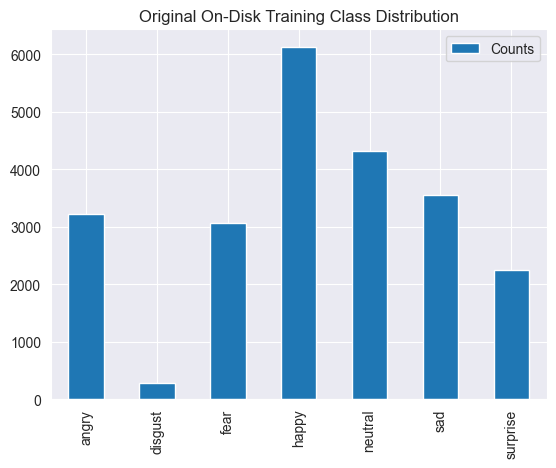

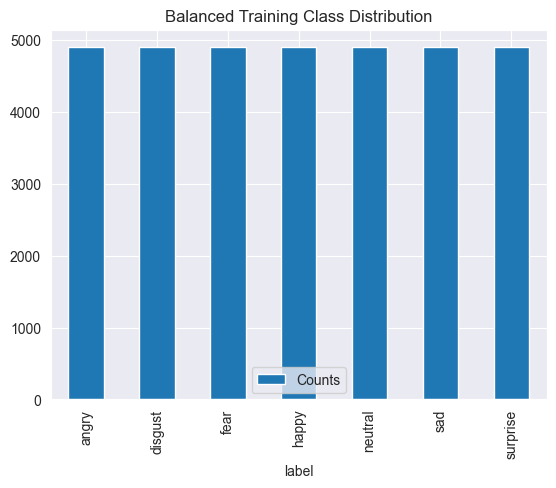

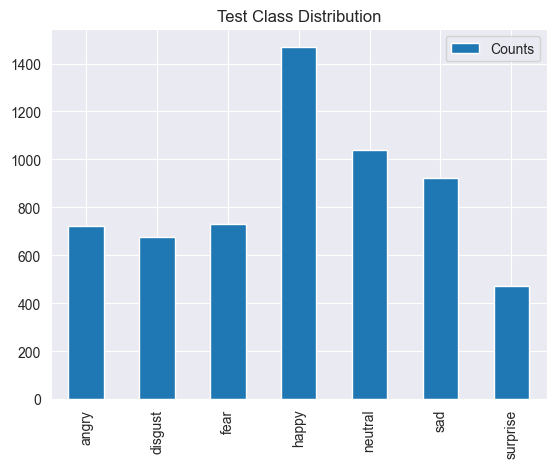

In [75]:
# Plot original on-disk training counts
train_count.transpose().plot(kind='bar', title="Original On-Disk Training Class Distribution")
plt.show()

# Plot balanced training counts
oversampled_train_count.transpose().plot(kind='bar', title="Balanced Training Class Distribution")
plt.show()

# Plot test counts (unchanged)
test_count.transpose().plot(kind='bar', title="Test Class Distribution")
plt.show()

In [76]:
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        # Ensure y_pred is clipped to avoid log(0)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)

        # Compute cross-entropy loss
        ce_loss = -y_true * tf.math.log(y_pred)

        # Compute focal factor: (1 - y_pred)^gamma for the true class
        focal_factor = tf.pow(1.0 - y_pred, self.gamma)

        # Apply focal factor and alpha weighting
        focal_loss = self.alpha * focal_factor * ce_loss

        # Sum over the class dimension and average over the batch
        return tf.reduce_mean(tf.reduce_sum(focal_loss, axis=-1))

In [77]:
def build_vgg16_model(num_classes=7):
    # Load pre-trained VGG16
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

    # Freeze VGG16 layers initially
    for layer in base_model.layers:
        layer.trainable = False

    # Input
    inputs = Input(shape=(48, 48, 3))

    # Pass through VGG16
    x = base_model(inputs, training=False)

    # Global average pooling to reduce spatial dimensions
    x = GlobalAveragePooling2D()(x)

    # Dense layers for classification
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    x = Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs, outputs, name='VGG16_FER')

    return model, base_model

# Build model
model, base_model = build_vgg16_model(num_classes=7)

# Compile Model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3, clipnorm=1.0, decay=1e-4),
    loss=FocalLoss(alpha=0.25, gamma=2.0),
    metrics=['accuracy']
)

# Model Summary
model.summary()

C:\Users\LENOVO\PycharmProjects\PsychoAI\.venv\Lib\site-packages\keras\src\optimizers\base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "VGG16_FER"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 1, 1, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,789,831 (56.42 MB)

 Trainable params: 74,759 (292.03 KB)

 Non-trainable params: 14,715,072 (56.13 MB)

In [78]:
# Balance the validation set
def balance_validation_data(val_data, target_count=1000):
    class_indices = val_data.class_indices
    idx_to_class = {v: k for k, v in class_indices.items()}

    image_paths = []
    labels = []
    for subdir in os.listdir(os.path.join(DATASET_DIRECTORY, "train")):
        subdir_path = os.path.join(DATASET_DIRECTORY, "train", subdir)
        if os.path.isdir(subdir_path):
            for img_name in os.listdir(subdir_path):
                if img_name.endswith(('.jpg', '.png')):
                    image_paths.append(os.path.join(subdir_path, img_name))
                    labels.append(class_indices[subdir])

    df = pd.DataFrame({'path': image_paths, 'label': labels})
    val_df = df.drop(df.sample(frac=0.8, random_state=42).index)  # Take the remaining 20%

    balanced_dfs = []
    for class_idx in class_indices.values():
        class_df = val_df[val_df['label'] == class_idx]
        current_count = len(class_df)
        if current_count < target_count:
            oversampled_class = resample(class_df, replace=True, n_samples=target_count - current_count, random_state=42)
            balanced_df = pd.concat([class_df, oversampled_class])
        elif current_count > target_count:
            balanced_df = resample(class_df, replace=False, n_samples=target_count, random_state=42)
        else:
            balanced_df = class_df
        balanced_dfs.append(balanced_df)

    balanced_val_df = pd.concat(balanced_dfs)
    balanced_val_df['label'] = balanced_val_df['label'].map(idx_to_class)

    val_datagen = ImageDataGenerator(rescale=1./255)
    val_data_balanced = val_datagen.flow_from_dataframe(
        balanced_val_df,
        x_col='path',
        y_col='label',
        target_size=image_size,
        batch_size=BATCH_SIZE,
        color_mode="rgb",
        class_mode="categorical",
        shuffle=False
    )

    return val_data_balanced

# Replace val_data with balanced validation data
val_data = balance_validation_data(val_data, target_count=1000)

Found 7000 validated image filenames belonging to 7 classes.


In [79]:
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    'best_vgg16_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

In [80]:
# Get the class labels assigned to each image in the training dataset
y_train = train_data.classes  # Extract labels from train_data

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert to dictionary format required by Keras
class_weights = dict(enumerate(class_weights))

In [81]:
class PrintTrainingProgress(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}: loss = {logs['loss']:.4f}, accuracy = {logs['accuracy']:.4f}, "
              f"val_loss = {logs['val_loss']:.4f}, val_accuracy = {logs['val_accuracy']:.4f}")

In [82]:
# Fine-Tune the Model
# Stage 1: Train the new layers
print("Stage 1: Training the new layers...")
history_initial = model.fit(
    train_data,
    validation_data=val_data,
    epochs=5,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint, PrintTrainingProgress()]
)

Stage 1: Training the new layers...
Epoch 1/5


C:\Users\LENOVO\PycharmProjects\PsychoAI\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


536/536 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.1929 - loss: 1.6004
Epoch 1: val_accuracy improved from -inf to 0.28914, saving model to best_vgg16_model.keras
Epoch 1: loss = 0.9626, accuracy = 0.2112, val_loss = 0.4144, val_accuracy = 0.2891
536/536 ━━━━━━━━━━━━━━━━━━━━ 106s 195ms/step - accuracy: 0.1929 - loss: 1.5992 - val_accuracy: 0.2891 - val_loss: 0.4144 - learning_rate: 0.0010
Epoch 2/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.2437 - loss: 0.4061
Epoch 2: val_accuracy did not improve from 0.28914
Epoch 2: loss = 0.3844, accuracy = 0.2521, val_loss = 0.3662, val_accuracy = 0.2571
536/536 ━━━━━━━━━━━━━━━━━━━━ 103s 192ms/step - accuracy: 0.2438 - loss: 0.4060 - val_accuracy: 0.2571 - val_loss: 0.3662 - learning_rate: 0.0010
Epoch 3/5
536/536 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.2639 - loss: 0.3534
Epoch 3: val_accuracy improved from 0.28914 to 0.30614, saving model to best_vgg16_model.keras
Epoch 3: loss = 0.3508, accuracy = 0.2659, val_loss =

In [83]:
print("\nStage 2: Fine-tuning the model...")
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile with a smaller learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0),  # Smaller learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_data,
    validation_data=val_data,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Stage 2: Fine-tuning the model...
Epoch 1/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 0s 515ms/step - accuracy: 0.3573 - loss: 1.6909
Epoch 1: val_accuracy improved from 0.30614 to 0.47814, saving model to best_vgg16_model.keras
536/536 ━━━━━━━━━━━━━━━━━━━━ 296s 546ms/step - accuracy: 0.3574 - loss: 1.6907 - val_accuracy: 0.4781 - val_loss: 1.3865 - learning_rate: 1.0000e-04
Epoch 2/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - accuracy: 0.5097 - loss: 1.3412
Epoch 2: val_accuracy improved from 0.47814 to 0.52286, saving model to best_vgg16_model.keras
536/536 ━━━━━━━━━━━━━━━━━━━━ 296s 552ms/step - accuracy: 0.5097 - loss: 1.3411 - val_accuracy: 0.5229 - val_loss: 1.2913 - learning_rate: 1.0000e-04
Epoch 3/10
536/536 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - accuracy: 0.5646 - loss: 1.1905
Epoch 3: val_accuracy improved from 0.52286 to 0.56486, saving model to best_vgg16_model.keras
536/536 ━━━━━━━━━━━━━━━━━━━━ 298s 555ms/step - accuracy: 0.5646 - loss: 1.1904 - val_accuracy: 0.5649 - val_loss: 1.21

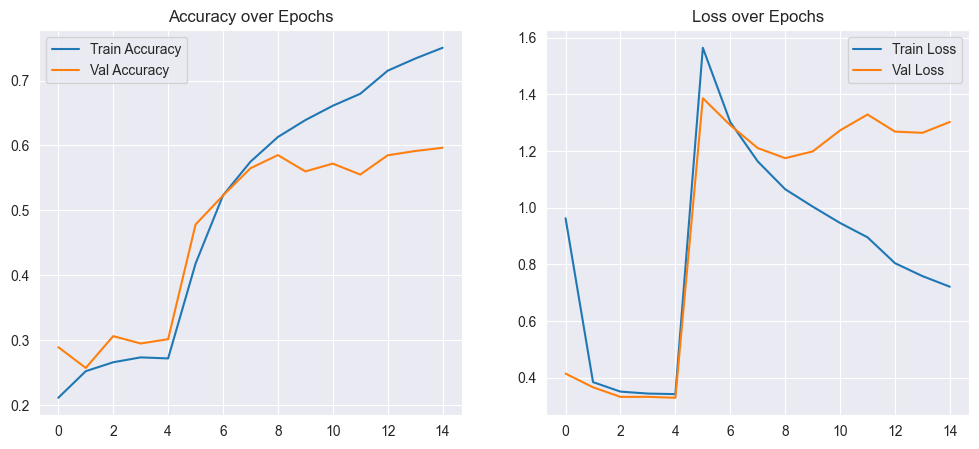

In [84]:
# Plotting Accuracy and Loss over Epochs
plt.figure(figsize=(12, 5))

# Combine histories
acc = history_initial.history['accuracy'] + history_fine.history['accuracy']
val_acc = history_initial.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history_initial.history['loss'] + history_fine.history['loss']
val_loss = history_initial.history['val_loss'] + history_fine.history['val_loss']

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Val Accuracy')
plt.legend()
plt.title("Accuracy over Epochs")

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")

plt.show()

C:\Users\LENOVO\PycharmProjects\PsychoAI\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step


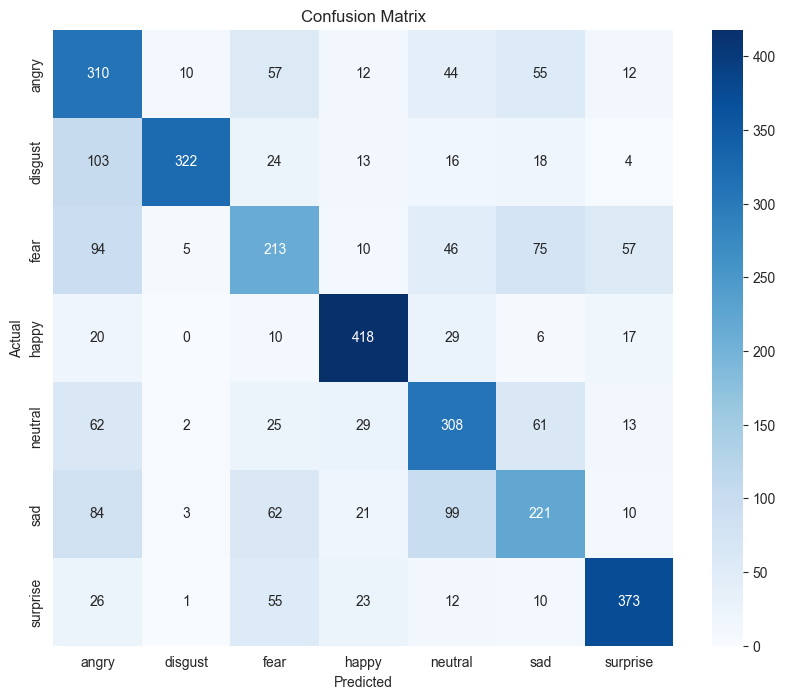

In [85]:
# Predict on test data
y_pred = model.predict(test_data)  # Using test_data (ImageDataGenerator for test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels from test_data (using the flow_from_directory)
y_true_classes = test_data.classes  # Extract true labels from the 'classes' attribute of the generator

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt='g',
            xticklabels=test_data.class_indices.keys(),  # Using class labels from the generator
            yticklabels=test_data.class_indices.keys())  # Using class labels from the generator
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [86]:
# Use the same predictions for classification report
y_pred_classes = np.argmax(y_pred, axis=1)  # Reuse y_pred

# Get true labels
y_true_classes = test_data.classes  # Extract true labels
class_labels = list(test_data.class_indices.keys())  # Get class names

# Generate Classification Report
report = classification_report(y_true_classes, y_pred_classes, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

       angry       0.44      0.62      0.52       500
     disgust       0.94      0.64      0.76       500
        fear       0.48      0.43      0.45       500
       happy       0.79      0.84      0.81       500
     neutral       0.56      0.62      0.58       500
         sad       0.50      0.44      0.47       500
    surprise       0.77      0.75      0.76       500

    accuracy                           0.62      3500
   macro avg       0.64      0.62      0.62      3500
weighted avg       0.64      0.62      0.62      3500



In [87]:
# Save the model
model.save("resnet50_vgg_hybrid_model.keras")

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Get predictions on the test set
test_data.reset()
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = test_data.labels

# Find misclassified examples for "disgust"
misclassified_indices = np.where((predicted_labels != true_labels) & (true_labels == test_data.class_indices['disgust']))[0]

# Plot a few misclassified examples
plt.figure(figsize=(15, 5))
for i, idx in enumerate(misclassified_indices[:5]):
    img, label = test_data[idx]
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"True: disgust\nPred: {list(test_data.class_indices.keys())[predicted_labels[idx]]}")
    plt.axis('off')
plt.show()

55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step


<Figure size 1500x500 with 0 Axes>